In [2]:
import sys
sys.path.append('../..')

In [3]:
from DeepDenoise.utils import deconv
from  DeepDenoise.utils import spectralfits
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib widget

## Load test data
For these tests, I am using a testset that consists in a continuous timeseries of synthetic biological signals with added noise. Noise has the largest magnitude used during neural network training.

In [4]:
# Load test timeseries
data = loadmat('/storage/ricardo/data/Project/Denoising/test_spect_all_noiseshot08.mat')
spect = data['spectest_full']   # With added noise
spect_clean = data['spectest']  # Without added noise

# Spectral features to be used in fittings
data_fits = loadmat('/storage/ricardo/data/Project/Denoising/noise_components_dataset_slowHb.mat')
ACh = data_fits['ACh_dynamics']
ACh_spec = data_fits['ACh_spectrum']  # ACh spectrum
HbO2_spec = data_fits['OxyHb_absorption']   # HbO2 spectrum
Hb_spec = data_fits['Hb_absorption']    # Hb spectrum

## Denoise

In [4]:
#denoise using selected models
model_names = ['DnCNN_absoluteF_depth20_ns03_700','DnCNN_absoluteF_depth20_ns08_700']
denoised = []

for i,model in enumerate(model_names):
    denoised_path = f"/storage/ricardo/data/Project/Denoising/denoised/denoised{i}.mat"
    model_path = f"../models/depth20/{model}.pth"
    denoised.append(spectralfits.denoise(spect,model_path,denoised_path,network_depth=20,save_file=True))

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


In [5]:
#load if necessary
denoised = []
for i in range(2):
    denoised_tm = loadmat(f"/storage/ricardo/data/Project/Denoising/denoised/denoised{i}.mat")
    denoised.append(denoised_tm['data'])

## Smooth

In [6]:
#Smooth with a gaussian kernel
from scipy.ndimage import gaussian_filter
sigmas = [0.5,0.6,1]
smooth = []
for sigma in sigmas:
    smooth.append(gaussian_filter(spect, sigma=sigma))

## Fit

In [7]:
#Make list with signals to fit
spect_list = [spect_clean,spect,smooth[0],smooth[1],smooth[2],denoised[0],denoised[1]]
signal_names = ['Ground truth','Raw','Smooth 0.5','Smooth 0.6','Smooth 1','Denoised 1','Denoised 2']
fit_ACh = []

# Fit spectral features
for spectra in spect_list:
    fit_tm = spectralfits.fit_ACh_spectra(spectra,ACh_spec,Hb_spec,HbO2_spec)
    fit_ACh.append(fit_tm[:,3])

#save if necessary
np.save('fit_ACh.npy',fit_ACh)

/storage/ricardo/miniconda3/envs/denoise/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [7]:
#make dictionary
spect_list = [spect_clean,spect,smooth[0],smooth[1],smooth[2],denoised[0],denoised[1]]
signal_names = ['Ground truth','Raw','Smooth 0.5','Smooth 0.6','Smooth 1','Denoised 1','Denoised 2']
spect_dict = {}
for name,sp in zip(signal_names,spect_list):
    spect_dict[name] = sp

In [8]:
#load fits if necessary
fits = np.load('fit_ACh.npy')
fit_ACh = {}
#convert to dictionary
for name,fit in zip(signal_names,fits):
    fit_ACh[name] = fit

del fits

## Dynamics of acetylcholine across brain states

During the day, mice go through 4 main brain states: active wake (WK), quiet wake (QW), non-REM sleep (NREM) and REM sleep (REM). Acetylcholine plays a key role in memmory encoding and sensory processing. Its extracellular concentration in the hippocampus is known to be highest during WK and REM.
The ground trhuth ACh dynamics from the test time-series was based on an in vivo fluorescence ACh recording and therefore represents how ACh changes accross brain states (Figure below).

### Remove baseline during NREM sleep

In [9]:
#load states
data_states = loadmat('/storage/ricardo/data/Freely_moving/Processed/States/ZY0719/20191016c/states.mat')
NREM = data_states['states']['NREM'][0][0]
indrA = spectralfits.get_elements_in_periods(NREM*5,np.arange(0,len(fit_ACh['Ground truth'])))

for name,signal in fit_ACh.items():
    AChfilt = spectralfits.ButFilter(signal,2,[0.2/(5/2)],'low').reshape(-1,1)
    min_NREM = np.min(AChfilt[indrA])
    fit_ACh[name] = fit_ACh[name]-min_NREM

print(np.shape(fit_ACh))


()


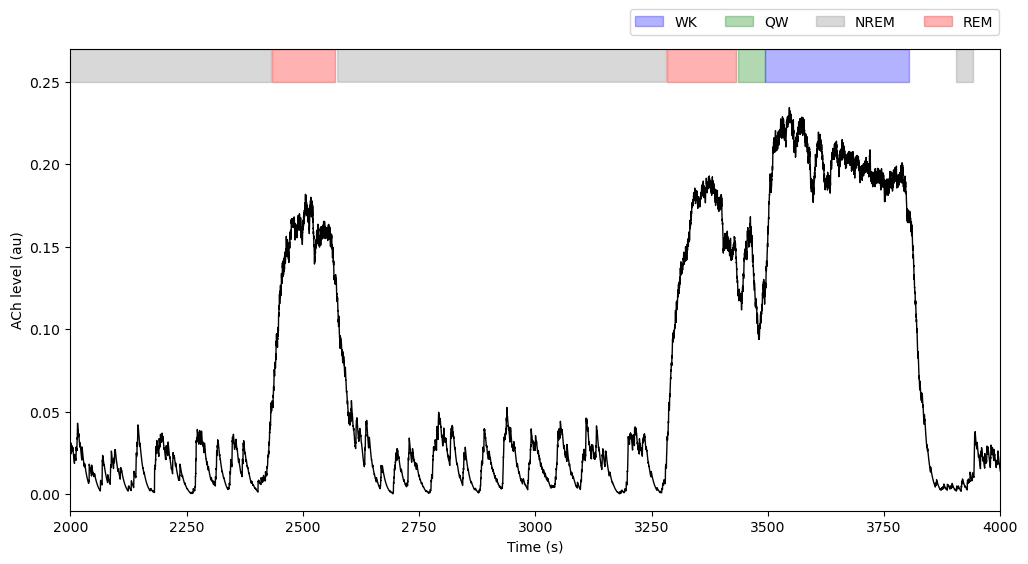

In [29]:
import matplotlib.patches as mpatches

#get the other states
WK = data_states['states']['WK'][0][0]
QW = data_states['states']['QW'][0][0]
REM = data_states['states']['REM'][0][0]

state_names = ['WK','QW','NREM','REM']

#Define colors for each state
state_colors = {
    "WK": "blue",
    "QW": "green",
    "NREM": "grey",
    "REM": "red"
}


fig, ax = plt.subplots(figsize=(12,6))
ax.plot(np.arange(len(ACh))/5,ACh,color='black',linewidth=1)

# draw shades states
for state_name in state_names:
    st = data_states['states'][state_name][0][0]
    color = state_colors[state_name]
    for period in st:
        #print(np.diff(period)[0])
        ax.fill_between(np.arange(period[0],period[1]),0.27,0.25,alpha=0.3,color=color)

# Create custom legend elements
legend_elements = []
for state, color in state_colors.items():
    legend_elements.append(mpatches.Patch(color=color, label=state, alpha=0.3))

# Add legend with custom elements above the figure
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(0.8, 1.1),ncol=4)

ax.set(xlabel='Time (s)', ylabel='ACh level (au)')
plt.xlim(2000,4000)
plt.ylim(-0.01,0.27)
plt.show()

It is clear that although the ACh average level is lowest during NREM sleep, it shows transient fast fluctuations (note that periods without unequivocal state classification were left as white spaces on the top shaded boxes).
In the following analysis we will focus on the ACh dynamics during NREM sleep, checking how the different signal processing procedures recapitulate different aspects of the ground thruth ACh dynamics. The figure below shows an example zoom-in on the ACh dynamics obtained with different methods during a NREM period. The most the signal traces follow the ground-thuth the better.

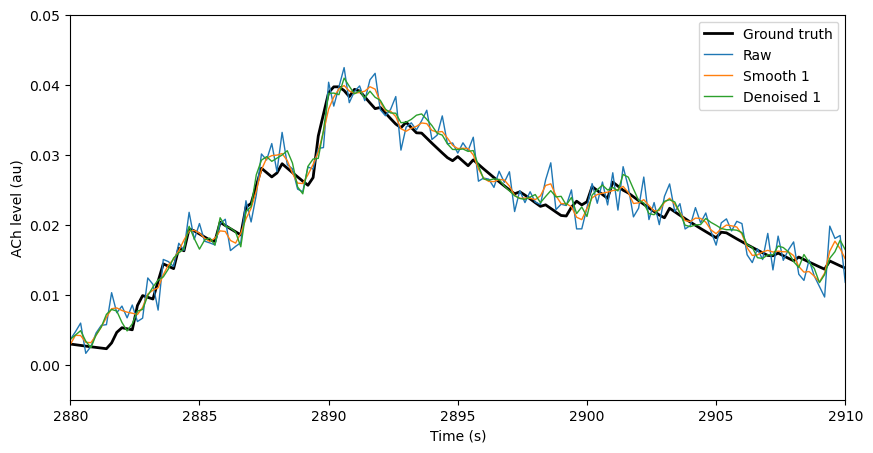

In [78]:
select_names = ['Ground truth','Raw','Smooth 1','Denoised 1']

fig, ax = plt.subplots(figsize=(10,5))
#plot signals
for name in select_names:
    if name=='Ground truth':
        ax.plot(np.arange(len(fit_ACh[name]))/5,fit_ACh[name],linewidth=2,color='black')
    else:
        ax.plot(np.arange(len(fit_ACh[name]))/5,fit_ACh[name],linewidth=1)

ax.set(xlabel='Time (s)', ylabel='ACh level (au)')
plt.xlim(2880,2910)
plt.ylim(-0.005,0.05)
ax.legend(select_names)
plt.show()

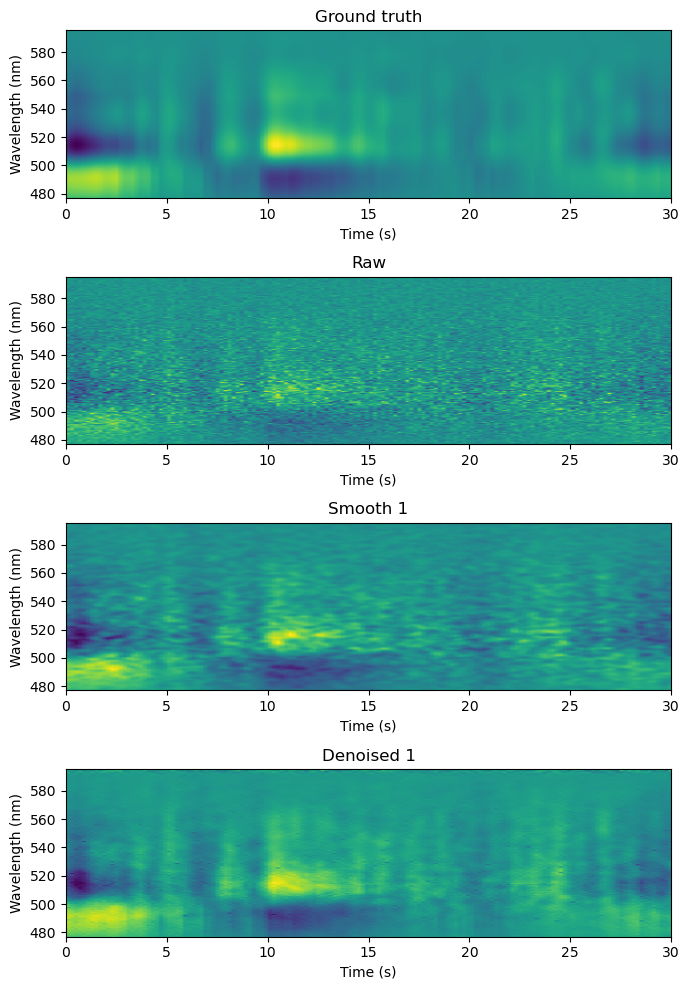

In [80]:
select_names = ['Ground truth','Raw','Smooth 1','Denoised 1']
wavelength = [476.924,595.404]

axis_lims = (0,30,wavelength[0],wavelength[1])

def FNormalize(data):
    mean_data = np.mean(data,axis=0,keepdims=True)
    return data-mean_data

fig, ax = plt.subplots(4,1,figsize=(7,10))
limits = [2880*5,2910*5]
len_seg = limits[1]-limits[0]
#plot signals
for i,name in enumerate(select_names):
    ax[i].imshow(np.flipud(FNormalize(spect_dict[name][limits[0]:limits[1],:]).T),aspect='auto',extent=axis_lims)
    ax[i].set(xlabel='Time (s)', ylabel='Wavelength (nm)',title=name)
    
plt.tight_layout()
plt.show()

## Deconvolute signals

In [11]:
#deconvolute processed signals
convfit = {}
deconv_signals = {}

for name,signal in fit_ACh.items():
    convfit_tm, deconvol_tm, _ = deconv.deconvolveCa_py(signal,0.9791,0)
    convfit[name] = convfit_tm
    deconv_signals[name] = deconvol_tm

#deconvolute ground thruth
#convfit_gt, deconvol_gt, _ = deconv.deconvolveCa_py(ACh,0.9791,0)

(44156, 1)
(129,)
[0.17785491097696596, 1, 44156, 1, 44155, nan]
[44154. 44155.    nan]


/storage/ricardo/miniconda3/envs/denoise/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/storage/ricardo/miniconda3/envs/denoise/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


15473
(44156, 1)
(129,)
[0.1763489762048256, 1, 44156, 1, 44155, nan]
[44154. 44155.    nan]
14583
(44156, 1)
(129,)
[0.17656778965159697, 1, 44156, 1, 44155, nan]
[44154. 44155.    nan]
16393
(44156, 1)
(129,)
[0.17670081287772804, 1, 44156, 1, 44155, nan]
[44154. 44155.    nan]
17706
(44156, 1)
(129,)
[0.17725052784159379, 1, 44156, 1, 44155, nan]
[44154. 44155.    nan]
21229
(44156, 1)
(129,)
[0.17751175991848694, 1, 44156, 1, 44155, nan]
[44154. 44155.    nan]
18847
(44156, 1)
(129,)
[0.18217175920933998, 1, 44156, 1, 44155, nan]
[44154. 44155.    nan]
22075


## Coherence with ground truth

In [14]:
from scipy.signal import coherence
from multitaper import MTSpec,MTCross
from spectral_connectivity import Multitaper,Connectivity

In [15]:
#Compute the power of the signals before deconvolution
ct = Multitaper(time_series=np.column_stack([fit_ACh[name] for name in fit_ACh]), 
                sampling_frequency=5,
                time_halfbandwidth_product=5,
                time_window_duration=32,
                time_window_step=16)

connect = Connectivity.from_multitaper(ct,expectation_type='time_trials_tapers',blocks=1)
power = connect.power()

#Compute coherence between signals and ground truth after deconvolution
ct = Multitaper(time_series=np.column_stack([deconv_signals[name] for name in deconv_signals]), 
                sampling_frequency=5,
                time_halfbandwidth_product=5,
                time_window_duration=32,
                time_window_step=16)

connect = Connectivity.from_multitaper(ct,expectation_type='time_trials_tapers',blocks=1)
coher = connect.coherence_magnitude()

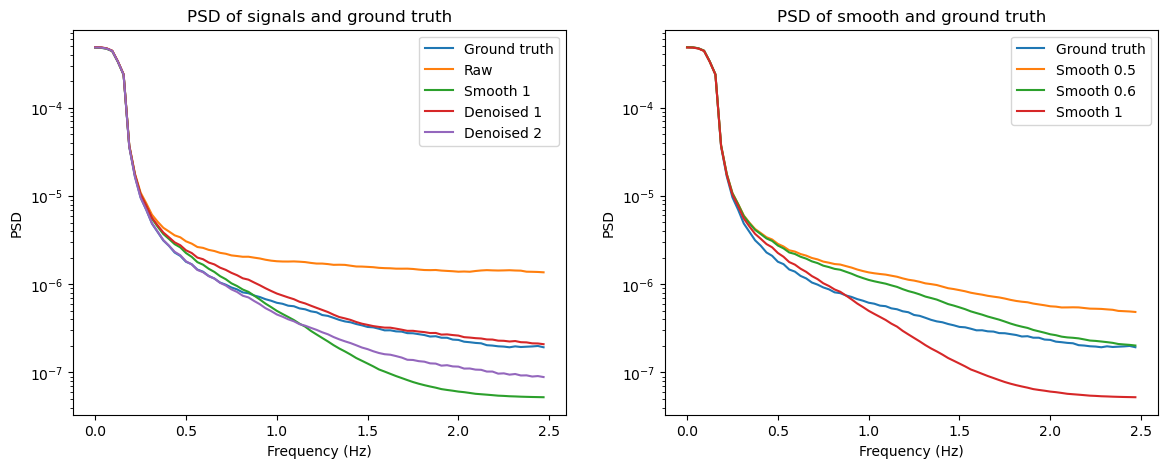

In [16]:
select_ind = [0,1,4,5,6]
fig,ax = plt.subplots(1,2,figsize=(14,5))
for i in select_ind:
    ax[0].semilogy(connect.frequencies,power[:,i].squeeze())
ax[0].set(xlabel='Frequency (Hz)',ylabel='PSD',title='PSD of signals and ground truth',label=[signal_names[i] for i in select_ind])
ax[0].legend([signal_names[i] for i in select_ind])

#then for different smoothing sigma
select_ind = [0,2,3,4]
for i in select_ind:
    ax[1].semilogy(connect.frequencies,power[:,i].squeeze())
ax[1].set(xlabel='Frequency (Hz)',ylabel='PSD',title='PSD of smooth and ground truth',label=[signal_names[i] for i in select_ind])
ax[1].legend([signal_names[i] for i in select_ind])

plt.show()

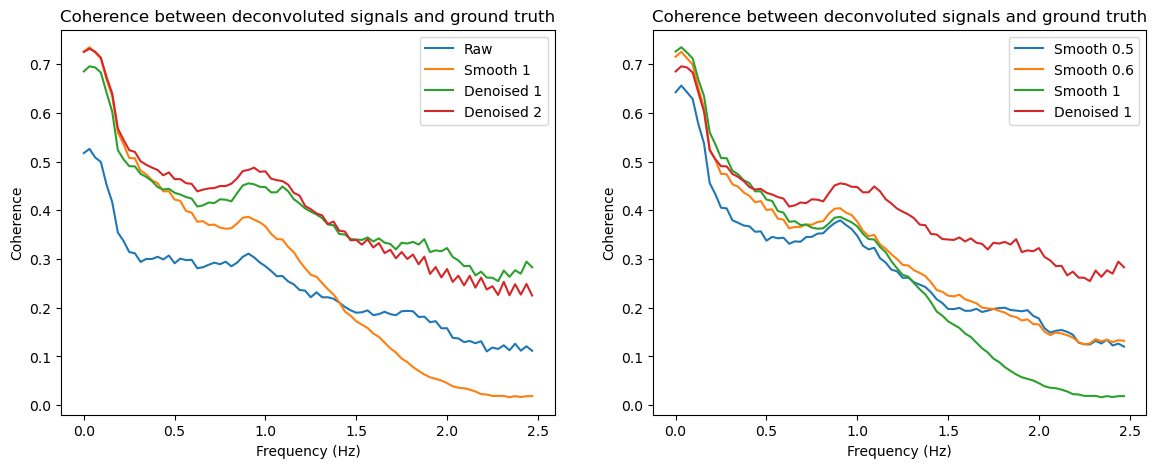

In [17]:
select_ind = [1,4,5,6]
fig,ax = plt.subplots(1,2,figsize=(14,5))
for i in select_ind:
    ax[0].plot(connect.frequencies,coher[:,0,i].squeeze())
ax[0].set(xlabel='Frequency (Hz)',ylabel='Coherence',title='Coherence between deconvoluted signals and ground truth',label=[signal_names[i] for i in select_ind])
ax[0].legend([signal_names[i] for i in select_ind])

#then for different smoothing sigma
select_ind = [2,3,4,5]
for i in select_ind:
    ax[1].plot(connect.frequencies,coher[:,0,i].squeeze())
ax[1].set(xlabel='Frequency (Hz)',ylabel='Coherence',title='Coherence between deconvoluted signals and ground truth',label=[signal_names[i] for i in select_ind])
ax[1].legend([signal_names[i] for i in select_ind])

## Detect peaks in deconvoluted signals

In [12]:
from scipy.signal import find_peaks, peak_prominences

In [13]:
#select the signals that we want to further analyse
select_names = ['Ground truth','Raw', 'Smooth 0.6', 'Denoised 1', 'Denoised 2']

#find peaks in each signal
peaks_deconv = []
amps_deconv = []
prominence_deconv = []
trise_deconv = []

period = np.column_stack([100, len(deconv_signals['Ground truth'])-100])

for name in select_names:
    signal = deconv_signals[name]
    peaks, _ = find_peaks(signal.squeeze(),height=0)
    peaks = spectralfits.get_elements_in_periods(period*5,peaks)
    amp = signal[peaks]
    prom = peak_prominences(signal.squeeze(),peaks)[0]
    trise = np.zeros(len(peaks))
    #find zeros preceeded by zeros
    original_ind = np.flip(np.arange(len(signal)))
    fl_signal = np.flip(signal)

    zeros = np.where(fl_signal==0)[0]
    zeros_pre = np.where(np.diff(zeros)==1)[0]
    zeros_pre = zeros[zeros_pre]
    zeros_seq = original_ind[zeros_pre]

    for i,peak in enumerate(peaks):
        #find closest zero_seq preceeding peak
        zeros_diff = peak - zeros_seq
        #select only the zeros_seq with positive zeros_diff
        zeros_seq_pos = zeros_seq[zeros_diff>0]
        #find index of closest zero_seq_pos
        ind = np.argmin(np.abs(zeros_seq_pos-peak))
        #find index of zero_seq
        ind_zero = zeros_seq_pos[ind]
        #calculate trise
        trise[i] = peak-ind_zero
    
    peaks_deconv.append(peaks)
    amps_deconv.append(amp)
    prominence_deconv.append(prom)
    trise_deconv.append(trise)

In [20]:
for i in range(len(peaks_deconv)):
	print(np.shape(peaks_deconv[i]))

(5015,)
(4586,)
(5689,)
(6085,)
(6665,)


## Amplitude and Trise

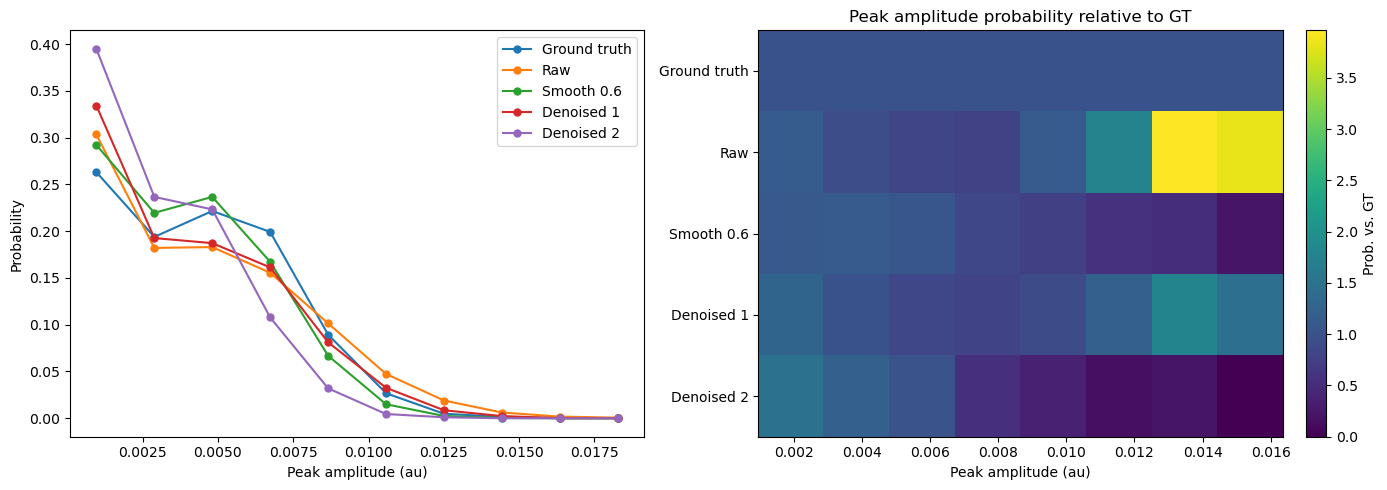

In [74]:
#histograms of amplitude of processed signals
hist_amp = []
#bins_amp = []
_,bins_amp = np.histogram(amps_deconv[1],bins=10)
bins_x = bins_amp[:-1] + np.diff(bins_amp)[0]/2

for i,amp in enumerate(amps_deconv):
    hist,bins = np.histogram(amp,bins=bins_amp)
    hist_amp.append(hist/len(amp))
    #bins_amp.append(bins)

fig,ax = plt.subplots(1,2,figsize=(14,5))

#plot histograms
for amp in hist_amp:
    ax[0].plot(bins_x,amp,marker='.',ms=10)

ax[0].set(xlabel='Peak amplitude (au)',ylabel='Probability',label=select_names)
ax[0].legend(select_names)

hist_data = np.column_stack(hist_amp)
implot = hist_data[:-2,:]/hist_data[:-2,0].reshape(-1,1)
cax = ax[1].imshow(implot.T,aspect='auto',extent=[bins_x[0],bins_x[-2],-0.5,len(select_names)-0.5])
ax[1].set(xlabel='Peak amplitude (au)',yticks=range(5),yticklabels=select_names[::-1],title='Peak amplitude probability relative to GT')
cbar = plt.colorbar(cax,fraction=0.046,pad=0.04)
cbar.set_label('Prob. vs. GT')
plt.tight_layout()
plt.show()


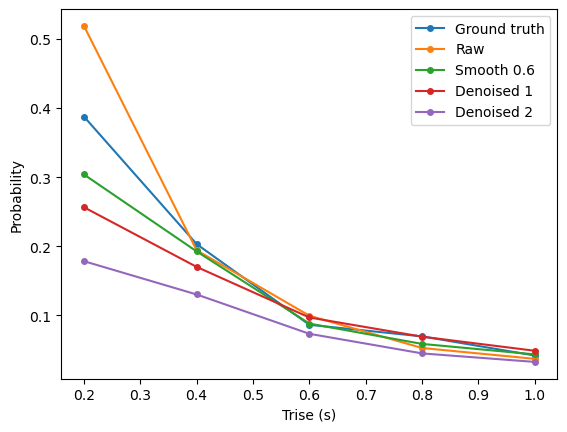

In [70]:
#histograms of Trise of processed signals
hist_trise = []
bins_trise = np.arange(0.5,6.5,1)/5

for i,trise in enumerate(trise_deconv):
    hist,bins = np.histogram(trise/5,bins=bins_trise)
    hist_trise.append(hist/len(trise))
    #bins_amp.append(bins)

#plot histograms
for trise in hist_trise:
    plt.plot(bins_trise[:-1]+0.1,trise,marker='.',ms=8) 

plt.legend(select_names)
plt.xlabel('Trise (s)')
plt.ylabel('Probability')
plt.show()

## Amplitude relationships

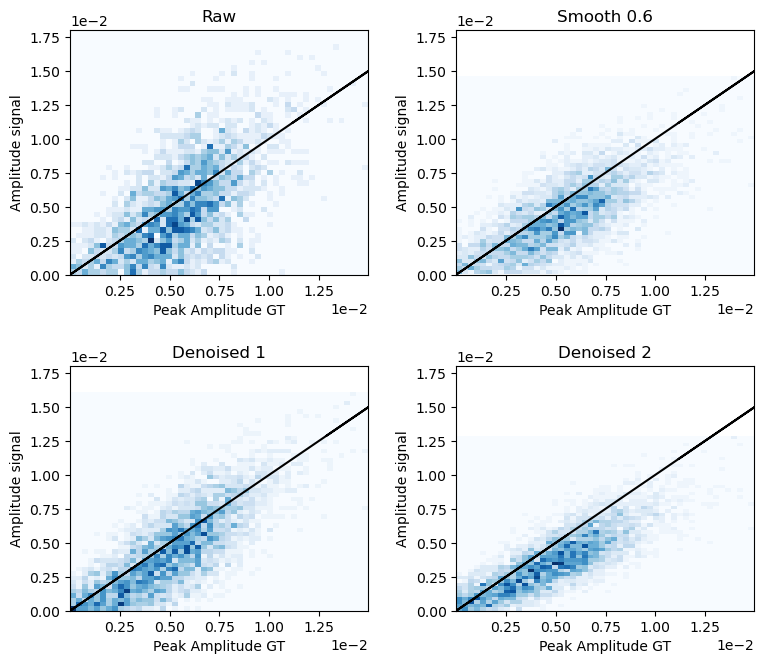

In [54]:
from scipy.stats import gaussian_kde,siegelslopes

fig,ax = plt.subplots(2,2,figsize=(8,7))

#low_slope = []
#high_slope = []

for i,name in enumerate(select_names[1:]):
    amp_signal = deconv_signals[name][peaks_deconv[0]]
    ind0 = (amp_signal>1e-6) & (amps_deconv[0]>1e-6)

    amp_signal = amp_signal[ind0]
    amp_gt = amps_deconv[0][ind0]
    #print(np.sum(amp_signal==0))
    #xy = np.vstack([amp_gt.T,amp_signal.T])
    #z = gaussian_kde(xy)(xy)
    #ax[i//2,i%2].scatter(amp_gt,amp_signal,c=z,s=20)
    ax[i//2,i%2].hist2d(amp_gt,amp_signal,bins=50,cmap='Blues')
    ax[i//2,i%2].set(title=name,xlabel='Peak Amplitude GT',ylabel='Amplitude signal')
    ax[i//2,i%2].set_ylim((0,0.018))
    ax[i//2,i%2].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
    ax[i//2,i%2].ticklabel_format(axis='x',style='sci',scilimits=(0,0))

    #low_gt = amp_gt<0.0025
    #high_gt = amp_gt>=0.0025
    #ls,li,_,_,_ = linregress(amp_gt[low_gt],amp_signal[low_gt])
    #ls,li = siegelslopes(amp_gt[low_gt],amp_signal[low_gt])
    #low_slope.append(ls)

    #pred_y = ls*amp_gt[low_gt]+li
    #ax[i//2,i%2].plot(amp_gt[low_gt],pred_y,color='red')

    #hs,hi,_,_,_ = linregress(amp_gt[high_gt],amp_signal[high_gt])
    #hs,hi = siegelslopes(amp_signal[high_gt],amp_gt[high_gt])
    #high_slope.append(hs)

    #ax[i//2,i%2].scatter(amp_gt[high_gt],amp_signal[high_gt])
    ax[i//2,i%2].plot(amp_gt,amp_gt,color='black')

plt.tight_layout(pad=2)
plt.show()

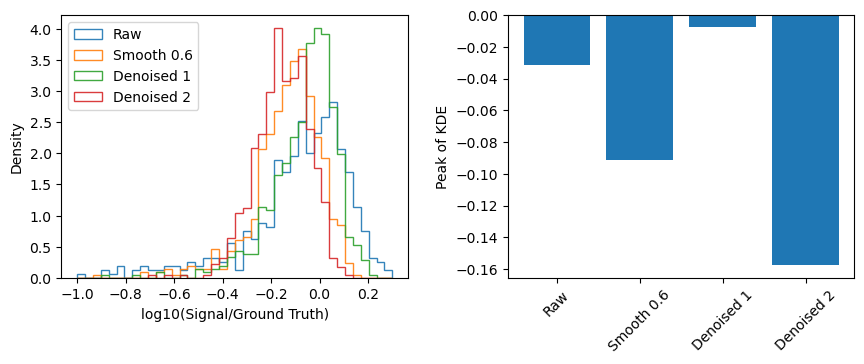

In [48]:
from scipy.stats import linregress

fig,ax = plt.subplots(1,2,figsize=(9,4))

high_ratio = []

for i,name in enumerate(select_names[1:]):
    amp_signal = deconv_signals[name][peaks_deconv[0]]
    ind0 = amp_signal>0
    amp_signal = amp_signal[ind0]
    amp_gt = amps_deconv[0][ind0]

    high_gt = amp_gt>=0.0075
   
    hr = np.log10(amp_signal[high_gt]/amp_gt[high_gt])
    #hr = amp_signal[high_gt]/amp_gt[high_gt]
    ax[0].hist(hr,histtype='step',alpha=0.9,bins=40,range=(-1,0.3),density=True,label=name)

    #calculate mode using kernel density estimate
    kde = gaussian_kde(hr)
    x = np.linspace(-1,0.5,1000)
    #ax[1].plot(x,kde(x),label=name)

    high_ratio.append(x[np.argmax(kde(x))])

ax[0].set(xlabel='log10(Signal/Ground Truth)',ylabel='Density')
ax[0].legend(loc=2)

ax[1].bar(select_names[1:],high_ratio)
ax[1].tick_params(axis='x',rotation=45)
ax[1].set(ylabel='Peak of KDE')
plt.tight_layout(pad=2)
plt.show()
    


## False negative and false positive rates in deconvoluted signal peaks

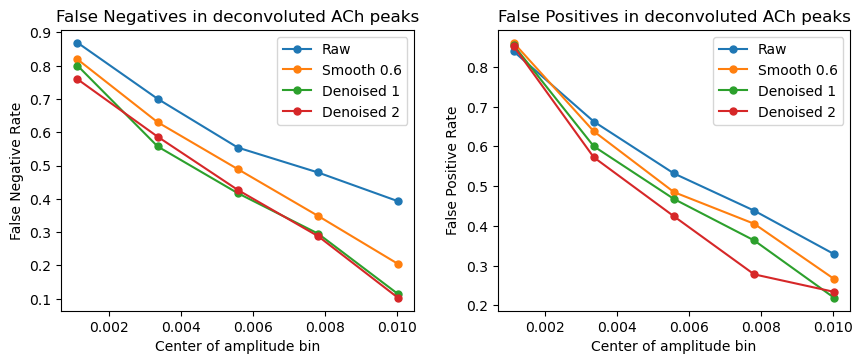

In [68]:
fig,ax = plt.subplots(1,2,figsize=(9,4))

#percentile bins
bins_amp = np.arange(0,np.quantile(amps_deconv[0],0.99),np.quantile(amps_deconv[0],0.99)/5)
bins_amp = np.append(bins_amp,10)
bin_ind = np.digitize(amps_deconv[0],bins_amp)-1
bins_x = bins_amp[:-1]+np.diff(bins_amp)[0]/2

# false negatives
fns = np.zeros((len(select_names)-1,len(bins_amp)-1))

for peaks_ind,peaks in enumerate(peaks_deconv[1:]):
    #find false negatives
    for i in np.arange(0,len(bins_amp)-1):
        n_correct = len(np.intersect1d(peaks_deconv[0][bin_ind.squeeze()==i],peaks))
        fns[peaks_ind,i] = (sum(bin_ind==i)-n_correct)/sum(bin_ind==i)

ax[0].plot(bins_x,fns.T,marker='.',ms=10)
ax[0].set(xlabel='Center of amplitude bin',ylabel='False Negative Rate',title='False Negatives in deconvoluted ACh peaks')
ax[0].legend(select_names[1:])

# false positives
fps = np.zeros((len(select_names)-1,len(bins_amp)-1))

for peaks_ind,peaks in enumerate(peaks_deconv[1:]):
    #digitize
    bin_ind = (np.digitize(amps_deconv[peaks_ind+1],bins_amp)-1).squeeze()
    #find false negatives
    for i in np.arange(0,len(bins_amp)-1):
        n_correct = len(np.intersect1d(peaks[bin_ind==i],peaks_deconv[0]))
        fps[peaks_ind,i] = (sum(bin_ind==i)-n_correct)/sum(bin_ind==i)

ax[1].plot(bins_x,fps.T,marker='.',ms=10)
ax[1].set(xlabel='Center of amplitude bin',ylabel='False Positive Rate',title='False Positives in deconvoluted ACh peaks')
ax[1].legend(select_names[1:])
plt.tight_layout(pad=2)
plt.show()
